In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from sklearn import preprocessing

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print('Running on GPU')
    print(torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')
    print('Running on CPU')

Running on GPU
NVIDIA GeForce GTX 1050 Ti with Max-Q Design


In [3]:
s_dir = './Stocks/CDNS_5y_12-23-21.csv'
#s_dir = './Stocks/CDNS.csv'

In [4]:
data = pd.read_csv(s_dir)

In [7]:
print(data.tail())
print(data.info())

            Date        Open        High         Low       Close   Adj Close  \
1252  2021-12-15  176.699997  184.410004  176.250000  184.270004  184.270004   
1253  2021-12-16  184.000000  184.009995  177.809998  179.619995  179.619995   
1254  2021-12-17  177.080002  182.449997  177.080002  179.149994  179.149994   
1255  2021-12-20  175.850006  178.619995  175.250000  177.320007  177.320007   
1256  2021-12-21  179.580002  183.289993  176.580002  183.029999  183.029999   

       Volume  
1252  1813100  
1253  1573400  
1254  3447100  
1255  1255100  
1256   980600  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1257 entries, 0 to 1256
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1257 non-null   object 
 1   Open       1257 non-null   float64
 2   High       1257 non-null   float64
 3   Low        1257 non-null   float64
 4   Close      1257 non-null   float64
 5   Adj Close  1257 non-null   float

In [6]:
data.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [6]:
np_data = data['Close'].to_numpy()

In [7]:
#Normalize datasets
scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
norm_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))



In [8]:
#print(closed_data)
norm_data

array([[-0.99337015],
       [-0.99189687],
       [-0.99791283],
       ...,
       [ 0.88987107],
       [ 0.86740346],
       [ 0.93750772]])

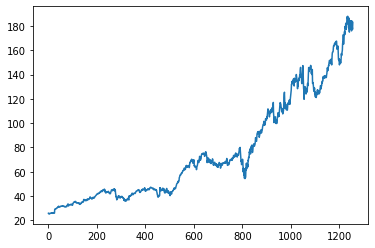

In [33]:
plt.plot(data['Close'])

In [16]:
print(np_train_set.shape)

(879, 1)


In [15]:
len(np_test_set)

378

In [9]:
def create_datasets(data, seq_len, pred_len):
    split = int(len(data)*0.8)
    seq_data = []
    data_len = len(data)
    
    for i in range(data_len-seq_len+1):
        seq_data.append(data[i:i+seq_len])
    seq_data = np.array(seq_data)
    
    #print(seq_data.shape)
    
    trn_x = seq_data[:split]
    trn_y = seq_data[:split, -1]
    tst_x = seq_data[split:]
    tst_y = seq_data[split:, -1]
    
    #print(trn_x.shape)
    #print(trn_y.shape)
    #print(tst_x.shape)
    #print(tst_y.shape)
        
    return trn_x, trn_y, tst_x, tst_y

In [84]:
sequence_l = 60
prediction_l = 30

train_x, train_y, test_x, test_y = create_datasets(norm_data, seq_len=sequence_l, pred_len=prediction_l)

#convert from np arry to pytorch tensor
train_x = torch.tensor(train_x).float() # convert list of numpy array to numpy array
train_y = torch.tensor(train_y).float()
test_x = torch.tensor(test_x).float()
test_y = torch.tensor(test_y).float()

print(train_x.shape)
print(train_y.shape)


torch.Size([1005, 60, 1])
torch.Size([1005, 1])


(1196, 60, 1)
[ 25.879999  25.389999  25.52     ... 163.100006 163.550003 158.160004]


In [11]:
class LSTM(nn.Module):
    def __init__(self, i_size, h_size, n_layers, drop):
        super(LSTM, self).__init__()
        self.num_layers = n_layers
        self.hidden_dim = h_size
        self.lstm = nn.LSTM(input_size=i_size ,hidden_size=h_size, num_layers=n_layers, batch_first=True, dropout=drop)
        self.layer1 = nn.Linear(h_size, 1)
        #
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
        output, (h, _) = self.lstm(x, (h0, c0))
        #x = F.relu(self.layer1(x))
        output = self.layer1(output[:,-1,:])
        return output
        

In [13]:
stock = LSTM(1, 32, 2, 0)
stock.to(device)

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (layer1): Linear(in_features=32, out_features=1, bias=True)
)

In [14]:
#Loss Function
loss_func = nn.MSELoss()

In [15]:
#Optimizer
optimizer = torch.optim.Adam(stock.parameters(), lr=0.01)

In [16]:
#Train Function
def train(model, epoch, loss_f, optimizer, device):
    losses = []
    model.train()
    
    #total_batches = int(len(train_x[0])/batch_size)
    
    for e in range (epoch):
        optimizer.zero_grad()
        inputs = train_x#[batch_n*batch_size:(batch_n+1)*batch_size]
        labels = train_y#[batch_n*batch_size:(batch_n+1)*batch_size]
        
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)

        #print('Output:',outputs)
        #print('Label:', labels)
        loss = loss_f(outputs, labels)
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
        print('Epoch Loss:', loss.item())
    

    #plt.plot(loss, label="Training loss")

In [88]:
#Test Function
def test(model, batch_size, loss_f, device):
    model.eval()

    #total_batches = int(len(test_x[0])/batch_size)
    
    #for batch_n in range(total_batches):
    inputs = test_x#[batch_n*batch_size:(batch_n+1)*batch_size]
    labels = test_y#[batch_n*batch_size:(batch_n+1)*batch_size]
        
    inputs, labels = inputs.to(device), labels.to(device)
        
    prediction = model(inputs)
    loss = loss_f(prediction, labels)
        
    scaled = scaler.inverse_transform(prediction.cpu().detach().numpy())
    plt.plot(scaled)
    print('Epoch MSE:', loss.item(), '%')

Epoch:  1
Epoch Loss: 0.00042585775372572243
Epoch Loss: 0.00042480617412365973
Epoch Loss: 0.00042375773773528636
Epoch Loss: 0.00042271160054951906
Epoch Loss: 0.0004216672095935792
Epoch Loss: 0.0004206253797747195
Epoch Loss: 0.00041958558722399175
Epoch Loss: 0.0004185474244877696
Epoch Loss: 0.0004175115318503231
Epoch Loss: 0.0004164780839346349
Epoch Loss: 0.0004154463531449437
Epoch Loss: 0.0004144166596233845
Epoch Loss: 0.0004133891488891095
Epoch Loss: 0.0004123632679693401
Epoch Loss: 0.0004113393952138722
Epoch Loss: 0.00041031779255717993
Epoch Loss: 0.00040929793613031507
Epoch Loss: 0.0004082799714524299
Epoch Loss: 0.00040726421866565943
Epoch Loss: 0.0004062501830048859
Epoch Loss: 0.00040523806819692254
Epoch Loss: 0.0004042278742417693
Epoch Loss: 0.0004032196302432567
Epoch Loss: 0.0004022131615784019
Epoch Loss: 0.0004012084973510355
Epoch Loss: 0.00040020589949563146
Epoch Loss: 0.0003992048732470721
Epoch Loss: 0.00039820600068196654
Epoch Loss: 0.0003972089325

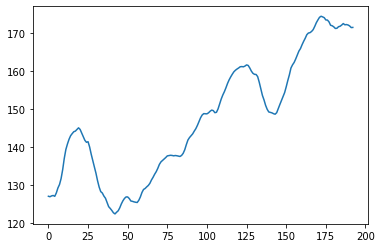

In [89]:
#Train/Test Script
for epoch in range(1,2):
    print('Epoch: ', epoch)
    train(stock, 30, loss_func, optimizer, device)
    test(stock, 30, loss_func, device)

In [90]:
test = stock(test_x[167,:,:].resize(1,60,1).to(device))
orig = scaler.inverse_transform(test.cpu().detach())
orig
#plt.plot(train)

C:\Users\brand\miniconda3\envs\general\lib\site-packages\torch\_tensor.py:493: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


array([[170.9615458]])

In [76]:
def predict30d(model, prev60, device):
    input60 = prev60
    norm30 = torch.empty((1,30,1), dtype=torch.float).to(device)
    real30 = torch.empty((1,30,1), dtype=torch.float).to(device)
    model.eval()
    for i in range(30):
        input60 = torch.cat((input60[:,i:,:], norm30[:,0:i,:]), 1)
        pred = model(input60)
        norm30[0,i,0] = pred
        real30[0,i,0] = (scaler.inverse_transform(pred.cpu().detach())[0,0])
    return real30, norm30
    

In [91]:
input60 = test_x[167,:,:].resize(1,60,1).to(device)
pred, scaled = predict30d(stock, input60, device)


C:\Users\brand\miniconda3\envs\general\lib\site-packages\torch\_tensor.py:493: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


In [98]:
p = torch.cat((scaler.inverse_transform(input60.cpu().detach()), pred), 1)

ValueError: Found array with dim 3. Estimator expected <= 2.

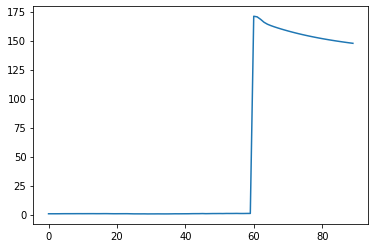

In [97]:
plt.plot(p.reshape(90,1))

In [ ]:
# save weights
torch.save(stock.state_dict(), "./StockModel.pt")

In [ ]:
#loader
stockModel = LSTM()
modelWeights = torch.load("./StockModel.pt")
stockModel.load_state_dict(modelWeights)

In [66]:
m = nn.Sequential(
    nn.LSTM(input_size=30, hidden_size=20, num_layers=3, batch_first=True, dropout=0.2),
    #nn.Linear(20,10),
    #nn.Linear(10, 1)
    #nn.Conv2d(1,16,7,stride=1,padding=2),
    #nn.MaxPool2d(kernel_size=3, stride=3),
    #nn.Conv2d(16,32,7,stride=1,padding=1),
    #nn.MaxPool2d(kernel_size=5, stride=3),
    #nn.Conv2d(32,64,3,stride=1,padding=1),
    #nn.MaxPool2d(kernel_size=2, stride=2),
    #nn.Flatten()
)

In [75]:
inputs = torch.randn(30,10,1)
print(inputs)
#output, (h_0,c_0) = m(inputs)
#output.size()

tensor([[[ 1.0781e-01],
         [ 3.6962e-01],
         [-2.8077e-01],
         [ 8.9057e-02],
         [-1.1219e+00],
         [-6.7937e-01],
         [ 1.0048e+00],
         [-9.8230e-01],
         [-1.5039e+00],
         [-3.7228e-01]],

        [[ 1.1369e+00],
         [ 9.5619e-01],
         [ 7.6198e-04],
         [ 1.7247e-01],
         [ 2.9469e-01],
         [ 1.8378e-01],
         [ 9.6322e-02],
         [-1.7440e-01],
         [-1.4952e+00],
         [ 2.1246e-02]],

        [[-8.9841e-01],
         [-4.7508e-01],
         [-1.0861e+00],
         [-2.0132e-01],
         [-2.4031e+00],
         [ 2.8254e-01],
         [ 1.1632e+00],
         [ 4.5747e-01],
         [-5.5225e-01],
         [-1.8980e-01]],

        [[-1.2350e+00],
         [ 4.2118e-01],
         [ 6.5976e-01],
         [-1.2103e+00],
         [ 1.5877e+00],
         [-1.7155e-02],
         [-9.2476e-01],
         [ 5.2618e-01],
         [-1.1711e+00],
         [ 1.0142e+00]],

        [[ 1.5482e+00],
        